In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import mylib as mylib

# Загрузка данных

In [2]:
data = pd.read_csv('datasets\\understat_per_game.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24580 entries, 0 to 24579
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   league        24580 non-null  object 
 1   year          24580 non-null  int64  
 2   h_a           24580 non-null  object 
 3   xG            24580 non-null  float64
 4   xGA           24580 non-null  float64
 5   npxG          24580 non-null  float64
 6   npxGA         24580 non-null  float64
 7   deep          24580 non-null  int64  
 8   deep_allowed  24580 non-null  int64  
 9   scored        24580 non-null  int64  
 10  missed        24580 non-null  int64  
 11  xpts          24580 non-null  float64
 12  result        24580 non-null  object 
 13  date          24580 non-null  object 
 14  wins          24580 non-null  int64  
 15  draws         24580 non-null  int64  
 16  loses         24580 non-null  int64  
 17  pts           24580 non-null  int64  
 18  npxGD         24580 non-nu

Выбранный датасет содержит результаты футбольных матчей в 6-ти лигах за сезоны 2014/2015 - 2019/2020.

In [3]:
data['league'].value_counts()

league
EPL           4560
La_liga       4560
Serie_A       4550
Ligue_1       4358
Bundesliga    3672
RFPL          2880
Name: count, dtype: int64

В датасете все матчи представлены дважды: по разу со стороны каждой команды.
Сводка по лигам:
- Английская и испанская лиги (EPL, La_liga) представлены полностью: 
    4560 записей = 10 матчей в туре (так как 20 команд в турнире) * 38 туров (какждый играет с каждым дважды) * 6 сезонов * 2 записей/матч
- Итальянская лига (Serie_A) - отсутсвует часть матчей последнего тур последнего сезона, что не влияет на дальнейшую работу.
- Французская лига (Ligue_1) - сезон 2019/2020 не был доигран из-за пандемии, поэтому матчей меньше.
- Немецкая лига (Bundesliga) представлена полностью (состав турнира = 18 команд)
- Российская лига (RFPL) представлена полностью (состав турнира = 16 команд)

# Постановка задачи

In [4]:
data['result'].value_counts(normalize=True)

result
w    0.373841
l    0.373841
d    0.252319
Name: proportion, dtype: float64

Задача: предсказывать результат матчей (классификация: победа, ничья, поражение) в чемпионате на основании информации о последних пяти матчах команд и количества набранных очков в сезоне на момент начала встречи.

Для оценки точности будем использовать точность (Accuracy) и многоклассовую f1-меру:
- Так как у нас достаточно сбалансированные классы, то показатель точности не будет сильно искажен. 
- Также, используем распространенную меру оценки качества классификации - f1-меру. Так как классы сбалансированы, то разница между макро и микро f1-мерой незначительна.
    
Выделим следующие показатели для простой модели:
- доля набранных очков за сезон - характеристика силы команды в сезоне
- доля набранных очков за предыдущие 5 матчей (в текущем сезоне) - характеристика текущей формы команды в сезоне
- количество забитых и пропущенных мячей в последних 5-ти матчах (в текущем сезоне) - характеристика текущей формы команды в сезоне
- играет ли команда дома - полагется, что игра дома увеличивает вероятность победы.

Набор признаков сформирован из предположения, что одна и та же команда в разные сезоны может сильно отличаться, именно поэтому признаки учитывают только предыдущую информацию в текущем сезоне.

# Формирование новых признаков

## Разделение матчей по сезонам

Требуется разметить все матчи по номеру сезона. Граница между сезонами - июнь. Посмторим распределение матчей по месяцам за весь представленный промежуток, убедимся в границе.

In [5]:
data['month'] = data['date'].str[:7]
count_by_months = data[['league','month','date']].groupby(['league','month']).count().reset_index()
count_by_months[count_by_months['month'].str[-2:].astype(int).between(6,8)]

league    month  date
0    Bundesliga  2014-08    36
10   Bundesliga  2015-08    54
20   Bundesliga  2016-08    18
30   Bundesliga  2017-08    36
40   Bundesliga  2018-08    20
50   Bundesliga  2019-08    50
59   Bundesliga  2020-06    94
60          EPL  2014-08    60
70          EPL  2015-08    80
80          EPL  2016-08    60
90          EPL  2017-08    60
100         EPL  2018-08    60
110         EPL  2019-08    76
118         EPL  2020-06    52
119         EPL  2020-07   132
120     La_liga  2014-08    40
130     La_liga  2015-08    40
140     La_liga  2016-08    40
150     La_liga  2017-08    40
160     La_liga  2018-08    46
170     La_liga  2019-08    52
178     La_liga  2020-06   106
179     La_liga  2020-07   114
180     Ligue_1  2014-08    80
190     Ligue_1  2015-08    80
200     Ligue_1  2016-08    60
210     Ligue_1  2017-08    80
220     Ligue_1  2018-08    62
230     Ligue_1  2019-08    72
238        RFPL  2014-08    96
246        RFPL  2015-07    34
247        RFPL  2015-08    78
255        RFPL  2016-07    12
256        RFPL  2016-08    68
264        RFPL  2017-07    48
265        RFPL  2017-08    80
273        RFPL  2018-07    16
274        RFPL  2018-08    66
282        RFPL  2019-07    48
283        RFPL  2019-08    74
290        RFPL  2020-06    34
291        RFPL  2020-07    94
292     Serie_A  2014-08    20
302     Serie_A  2015-08    40
312     Serie_A  2016-08    40
322     Serie_A  2017-08    40
332     Serie_A  2018-08    38
342     Serie_A  2019-08    26
350     Serie_A  2020-06    52
351     Serie_A  2020-07   176
352     Serie_A  2020-08    10

Как видно из представленной таблицы за исключением 2020-го года (перенос матчей из-за пандемии), во всех лигах не проводятся матчи в июне. Поэтому будем считать Июнь - границей между сезонами.
Добавим новый признак - номер сезона, так что 2014/2015 - 1, ... 2019/2020 - 6.

In [6]:
data['season_number'] = data['date'].astype('str').apply(mylib.get_season_number)

data[['date','season_number']].sample(n=10, random_state=11)

date  season_number
873    2016-03-02 23:00:00              2
10106  2016-11-27 23:45:00              3
7918   2020-03-07 15:00:00              6
19357  2019-03-01 13:30:00              5
17587  2015-03-09 12:30:00              1
17758  2015-09-18 20:00:00              2
1003   2016-01-23 18:30:00              2
3310   2019-12-02 19:30:00              6
17913  2015-11-01 20:00:00              2
19499  2018-10-05 16:30:00              5

## Добавление признаков

Разметим команду противника в каждом матче и удалим неиспользуемые признаки.

In [7]:
data_merged = data.merge(data[["team", "xG", "xGA", "date",'scored', 'missed', 'ppda_coef']], 
                         left_on=['date','xG', 'xGA', 'scored', 'missed', 'oppda_coef'], 
                         right_on=['date','xGA', 'xG', 'missed', 'scored', 'ppda_coef'],
                         suffixes=('','_opp'), validate='one_to_one')

data_merged_filtered = data_merged[['season_number', 'h_a', 'team', 'team_opp', 'scored', 'missed',
                                    'result', 'pts','league','date']].copy()
data_merged_filtered.head()

season_number h_a           team       team_opp  scored  missed result  \
0              1   h  Bayern Munich      Wolfsburg       2       1      w   
1              1   a  Bayern Munich     Schalke 04       1       1      d   
2              1   h  Bayern Munich  VfB Stuttgart       2       0      w   
3              1   a  Bayern Munich   Hamburger SV       0       0      d   
4              1   h  Bayern Munich      Paderborn       4       0      w   

   pts      league                 date  
0    3  Bundesliga  2014-08-22 19:30:00  
1    1  Bundesliga  2014-08-30 17:30:00  
2    3  Bundesliga  2014-09-13 14:30:00  
3    1  Bundesliga  2014-09-20 14:30:00  
4    3  Bundesliga  2014-09-23 19:00:00

Посчитаем сумму очков к моменту начала матча, к концу мачта, тур/номер матча для команды (в соответствии с датой, не реальным расписанием игр). Посчитаем количество очков, забитых и пропущенных голов за последние 5 матчей в пределах текущего сезона для каждого матча.

Добавим все характеристики в качестве новых признаков к датасету.

In [8]:
LAST_MATCHES_AMOUNT = 5

grouped = data_merged_filtered.groupby(by=['season_number','team'], sort=['date'])
data_grouped = data_merged_filtered.copy()

data_grouped['points_after'] = grouped['pts'].cumsum()
data_grouped['points_before'] = data_grouped['points_after'] - data_grouped['pts']
data_grouped['round'] = grouped.cumcount() + 1
data_grouped['points_last_match'] = grouped['pts'].shift(1)

data_grouped[['points_last_matches', 'scored_last_matches', 'missed_last_matches']] = (
    grouped[['pts', 'scored', 'missed']].rolling(LAST_MATCHES_AMOUNT, closed='left').
    sum().reset_index(level=[0,1])[['pts', 'scored', 'missed']]
)

data_grouped.drop(['league', 'date'], axis=1).head(10)

season_number h_a           team             team_opp  scored  missed  \
0              1   h  Bayern Munich            Wolfsburg       2       1   
1              1   a  Bayern Munich           Schalke 04       1       1   
2              1   h  Bayern Munich        VfB Stuttgart       2       0   
3              1   a  Bayern Munich         Hamburger SV       0       0   
4              1   h  Bayern Munich            Paderborn       4       0   
5              1   a  Bayern Munich           FC Cologne       2       0   
6              1   h  Bayern Munich          Hannover 96       4       0   
7              1   h  Bayern Munich        Werder Bremen       6       0   
8              1   a  Bayern Munich  Borussia M.Gladbach       0       0   
9              1   h  Bayern Munich    Borussia Dortmund       2       1   

  result  pts  points_after  points_before  round  points_last_match  \
0      w    3             3              0      1                NaN   
1      d    1             4              3      2                3.0   
2      w    3             7              4      3                1.0   
3      d    1             8              7      4                3.0   
4      w    3            11              8      5                1.0   
5      w    3            14             11      6                3.0   
6      w    3            17             14      7                3.0   
7      w    3            20             17      8                3.0   
8      d    1            21             20      9                3.0   
9      w    3            24             21     10                1.0   

   points_last_matches  scored_last_matches  missed_last_matches  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN                  NaN  
2                  NaN                  NaN                  NaN  
3                  NaN                  NaN                  NaN  
4                  NaN                  NaN                  NaN  
5                 11.0                  9.0                  2.0  
6                 11.0                  9.0                  1.0  
7                 13.0                 12.0                  0.0  
8                 13.0                 16.0                  0.0  
9                 13.0                 16.0                  0.0

Добавим для каждого матча классическую запись результата в качестве отдельного признака по форме:

"команда хозяин" "забитые мячи хозяев":"забитые мячи гостей" "команда гость", пример: Bayern Munich 2:1 Wolfsburg

In [9]:
data_grouped['match_label'] = data_grouped.apply(lambda x: mylib.create_match_label(x['h_a'], x['team'],  x['team_opp'],  x['scored'],  x['missed']), axis=1)
data_grouped[['h_a','points_before', 'pts', 'points_after', 'match_label', 'round']]

h_a  points_before  pts  points_after                      match_label  \
0       h              0    3             3      Bayern Munich 2:1 Wolfsburg   
1       a              3    1             4     Schalke 04 1:1 Bayern Munich   
2       h              4    3             7  Bayern Munich 2:0 VfB Stuttgart   
3       a              7    1             8   Hamburger SV 0:0 Bayern Munich   
4       h              8    3            11      Bayern Munich 4:0 Paderborn   
...    ..            ...  ...           ...                              ...   
24575   h             29    0            29             Lecce 1:3 Fiorentina   
24576   a             29    0            29                  Genoa 2:1 Lecce   
24577   h             29    3            32                Lecce 3:1 Brescia   
24578   a             32    0            32                Bologna 3:2 Lecce   
24579   a             32    3            35                Udinese 1:2 Lecce   

       round  
0          1  
1          2  
2          3  
3          4  
4          5  
...      ...  
24575     33  
24576     34  
24577     35  
24578     36  
24579     37  

[24580 rows x 6 columns]

# Подготовка признаков

Разметим показатели противостоящей команды и оставим только указанные показатели, требуемые для обучения модели. Удалим строки NaN, то есть первые матчи сезона, так как для них невозможно расчитать показатели последних 5-ти матчей.

In [10]:
data_to_train_full = data_grouped.merge(data_grouped[['match_label', 'date', 'team', 'points_last_matches', 
                                                 'scored_last_matches', 'missed_last_matches', 'points_before', 'round']],
                                        left_on=['match_label','date', 'team_opp'], 
                                        right_on=['match_label','date', 'team'],
                                        suffixes=('','_opp'), validate='one_to_one'
                                       )
data_to_train_full['ishome'] = data_to_train_full['h_a'] == 'h'
data_to_train_dropna = data_to_train_full[['points_before', 'points_last_matches', 'scored_last_matches', 'missed_last_matches',
                                           'points_before_opp', 'points_last_matches_opp', 'scored_last_matches_opp', 
                                           'missed_last_matches_opp','ishome', 'result', 'round', 'round_opp'
                                          ]].copy().dropna()

## Выделение долей и средних показателей

Переведем суммарное количество очков в долю от максимального, а сумму голов - в среднее за матчи.

In [11]:
data_to_train = pd.DataFrame()
data_to_train['points_last_matches'] = data_to_train_dropna['points_last_matches'] / (LAST_MATCHES_AMOUNT*3)
data_to_train['points_last_matches_opp'] = data_to_train_dropna['points_last_matches_opp'] / (LAST_MATCHES_AMOUNT*3)

data_to_train['scored_last_matches'] = data_to_train_dropna['scored_last_matches'] / LAST_MATCHES_AMOUNT
data_to_train['scored_last_matches_opp'] = data_to_train_dropna['scored_last_matches_opp'] / LAST_MATCHES_AMOUNT

data_to_train['missed_last_matches'] = data_to_train_dropna['missed_last_matches'] / LAST_MATCHES_AMOUNT
data_to_train['missed_last_matches_opp'] = data_to_train_dropna['missed_last_matches_opp'] / LAST_MATCHES_AMOUNT

data_to_train['points_before'] = data_to_train_dropna['points_before'] / ((data_to_train_dropna['round'] - 1) * 3)
data_to_train['points_before_opp'] = data_to_train_dropna['points_before_opp'] / ((data_to_train_dropna['round_opp'] - 1) * 3)
data_to_train[['ishome', 'result']] = data_to_train_dropna[['ishome', 'result']]
data_to_train.describe()

points_last_matches  points_last_matches_opp  scored_last_matches  \
count         21152.000000             21152.000000         21152.000000   
mean              0.457549                 0.457549             1.332820   
std               0.226256                 0.226256             0.667785   
min               0.000000                 0.000000             0.000000   
25%               0.266667                 0.266667             0.800000   
50%               0.466667                 0.466667             1.200000   
75%               0.600000                 0.600000             1.600000   
max               1.000000                 1.000000             5.000000   

       scored_last_matches_opp  missed_last_matches  missed_last_matches_opp  \
count             21152.000000         21152.000000             21152.000000   
mean                  1.332820             1.332139                 1.332139   
std                   0.667785             0.599115                 0.599115   
min                   0.000000             0.000000                 0.000000   
25%                   0.800000             1.000000                 1.000000   
50%                   1.200000             1.200000                 1.200000   
75%                   1.600000             1.800000                 1.800000   
max                   5.000000             4.200000                 4.200000   

       points_before  points_before_opp  
count   21152.000000       21152.000000  
mean        0.457490           0.457490  
std         0.170258           0.170258  
min         0.000000           0.000000  
25%         0.333333           0.333333  
50%         0.435897           0.435897  
75%         0.561404           0.561404  
max         1.000000           1.000000

Исходя из представленных характеристик видно, что показатели, связанные с очками (доля набранных очков за сезон, доля набранных очков за предыдущие 5 матчей), нормализованы верно (минимальное значение = 0, максимальное значение = 1).

## Анализ выбросов

Посмторим распределение показателей, связанных с голами в последних матчей. Так как показатели для первой и второй команда (\_opp) одинаковы с точностью до перестановок, рассмотрим только показатели для первой команды.

<Axes: xlabel='missed_last_matches'>

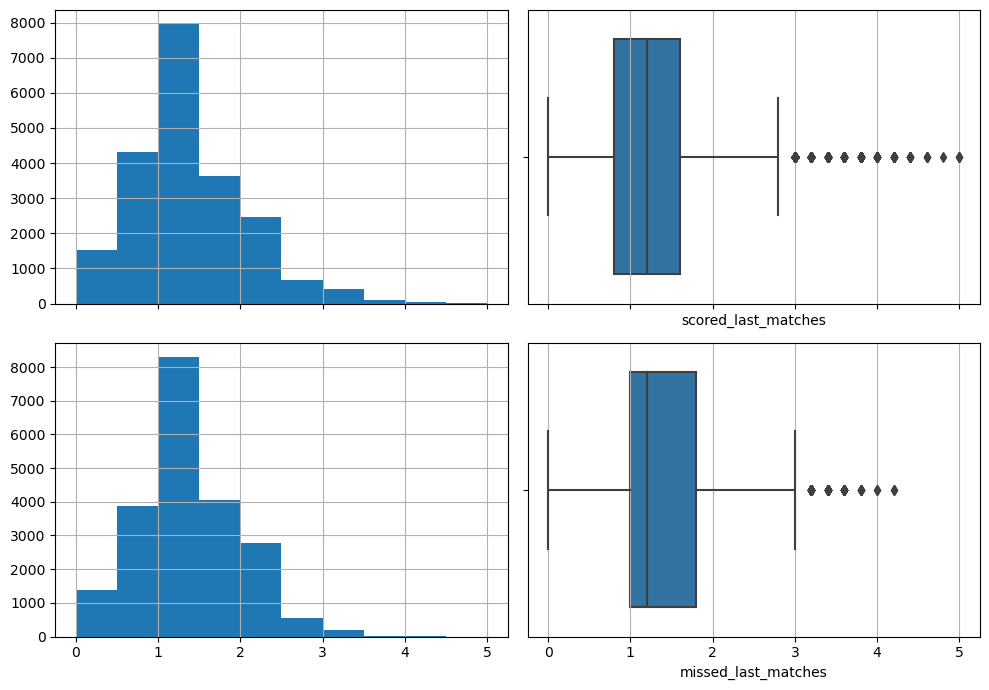

In [12]:
fig, axs = plt.subplots(2, 2, sharex=True, tight_layout=True, figsize=(10, 7))
axs[0,0].grid()
axs[1,0].grid()
axs[0,0].hist(data_to_train['scored_last_matches'], np.arange(0,5.5,0.5))
axs[1,0].hist(data_to_train['missed_last_matches'], np.arange(0,5.5,0.5))
axs[0,1].grid(axis='x')
sns.boxplot(x=data_to_train['scored_last_matches'], ax=axs[0,1])
axs[1,1].grid(axis='x')
sns.boxplot(x=data_to_train['missed_last_matches'], ax=axs[1,1])

In [13]:
data_to_train[['scored_last_matches', 'missed_last_matches']].quantile(0.95)

scored_last_matches    2.6
missed_last_matches    2.4
Name: 0.95, dtype: float64

На основании предложенных графиков и показателей, можно сказать, что среднее значение около 3 и выше забитых/пропущенных мячей в среднем за последние 5 матчей является редким, поэтому будем считать такие матчи выбросами и отфильтруем их. 
А также нормализуем, поделив на 3 все показатели с забитыми/пропущенными мячами.

In [14]:
MAX_SCORED_LAST_MATCHES = 3
data_to_train_filtered = data_to_train[(data_to_train['scored_last_matches'] <= MAX_SCORED_LAST_MATCHES) & 
                                       (data_to_train['missed_last_matches'] <= MAX_SCORED_LAST_MATCHES) &
                                       (data_to_train['scored_last_matches_opp'] <= MAX_SCORED_LAST_MATCHES) & 
                                       (data_to_train['missed_last_matches_opp'] <= MAX_SCORED_LAST_MATCHES)].copy()
goals_info = data_to_train_filtered[['scored_last_matches', 'missed_last_matches', 
                                   'scored_last_matches_opp', 'missed_last_matches_opp']]
scaler = MinMaxScaler()
scaler.fit(goals_info)
data_to_train_filtered[['scored_last_matches', 'missed_last_matches', 
                        'scored_last_matches_opp', 'missed_last_matches_opp']] = scaler.transform(goals_info)
data_to_train_filtered.describe()

points_last_matches  points_last_matches_opp  scored_last_matches  \
count         20170.000000             20170.000000         20170.000000   
mean              0.452216                 0.452216             0.431820   
std               0.219754                 0.219754             0.200958   
min               0.000000                 0.000000             0.000000   
25%               0.266667                 0.266667             0.266667   
50%               0.466667                 0.466667             0.400000   
75%               0.600000                 0.600000             0.533333   
max               1.000000                 1.000000             1.000000   

       scored_last_matches_opp  missed_last_matches  missed_last_matches_opp  \
count             20170.000000         20170.000000             20170.000000   
mean                  0.431820             0.442667                 0.442667   
std                   0.200958             0.193178                 0.193178   
min                   0.000000             0.000000                 0.000000   
25%                   0.266667             0.333333                 0.333333   
50%                   0.400000             0.400000                 0.400000   
75%                   0.533333             0.600000                 0.600000   
max                   1.000000             1.000000                 1.000000   

       points_before  points_before_opp  
count   20170.000000       20170.000000  
mean        0.453242           0.453242  
std         0.165517           0.165517  
min         0.000000           0.000000  
25%         0.333333           0.333333  
50%         0.433333           0.433333  
75%         0.555556           0.555556  
max         1.000000           1.000000

# Обучение модели

Разделение на тестовую и тренировочную выборки.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_to_train_filtered.drop(['result'], axis=1), 
                                                    data_to_train_filtered['result'], 
                                                    random_state=3456, test_size=0.25)
report_full = pd.DataFrame(columns=['accuracy', 'f1_score'])

## Константный предсказатель

In [16]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

report_full.loc['DummyClassifier'] = [accuracy_score(y_test, y_pred_dummy),
                                      f1_score(y_test, y_pred_dummy, average='macro')]
print(classification_report(y_test, y_pred_dummy, zero_division=0))

              precision    recall  f1-score   support

           d       0.00      0.00      0.00      1346
           l       0.00      0.00      0.00      1873
           w       0.36      1.00      0.53      1824

    accuracy                           0.36      5043
   macro avg       0.12      0.33      0.18      5043
weighted avg       0.13      0.36      0.19      5043



## Логистическая регрессия

In [17]:
model = LogisticRegression(multi_class='ovr', random_state=1111)
model.fit(X_train, y_train)

y_preds_logistic_regr = model.predict(X_test)

report_full.loc['LogisticRegression'] = [accuracy_score(y_test, y_preds_logistic_regr), 
                                         f1_score(y_test, y_preds_logistic_regr, average='macro')]
print(classification_report(y_test,y_preds_logistic_regr, zero_division=0))

              precision    recall  f1-score   support

           d       0.00      0.00      0.00      1346
           l       0.51      0.67      0.58      1873
           w       0.49      0.70      0.58      1824

    accuracy                           0.50      5043
   macro avg       0.33      0.45      0.38      5043
weighted avg       0.37      0.50      0.42      5043



## Метод kNN

In [18]:
knn = KNeighborsClassifier(n_neighbors=30, weights='uniform')
knn.fit(X_train, y_train)

y_preds_knn = knn.predict(X_test)

report_full.loc['KNeighborsClassifier'] = [accuracy_score(y_test, y_preds_knn), 
                                           f1_score(y_test, y_preds_knn, average='macro')]
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           d       0.30      0.10      0.15      1346
           l       0.50      0.61      0.55      1873
           w       0.49      0.62      0.55      1824

    accuracy                           0.48      5043
   macro avg       0.43      0.44      0.42      5043
weighted avg       0.44      0.48      0.44      5043



## Подведение итогов

In [19]:
report_full

accuracy  f1_score
DummyClassifier       0.361689  0.177079
LogisticRegression    0.499901  0.384589
KNeighborsClassifier  0.477295  0.416041

# Графики набора очков командами с использованием библиотеки Plotly

Построим для каждой лиги собственные графики со следующими характеристиками.
- На каждом графике имеется возможность выбора отображаемого сезона.
- На каждом графике каждой команде соответствует одна линия, причем соответствие между цветом этой линии и командой отображено в легенде.
- Каждой команде соответствует одна зависимость (линия на графике) такая, что по оси х - тур (игровой день), у - количество очков.
- Каждой точке на всех графиках соответствует один матч, причем результат матча отображается при наведении на интересующую точку в появляющемся лейбле.

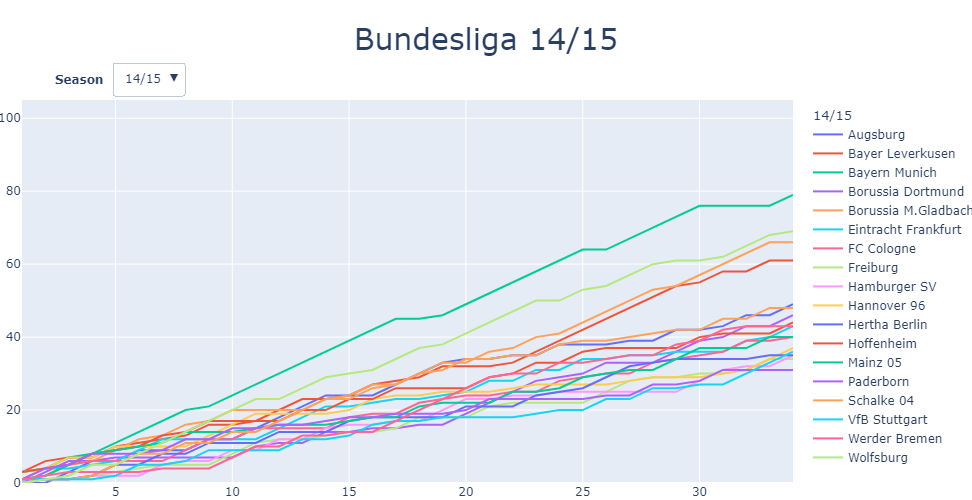

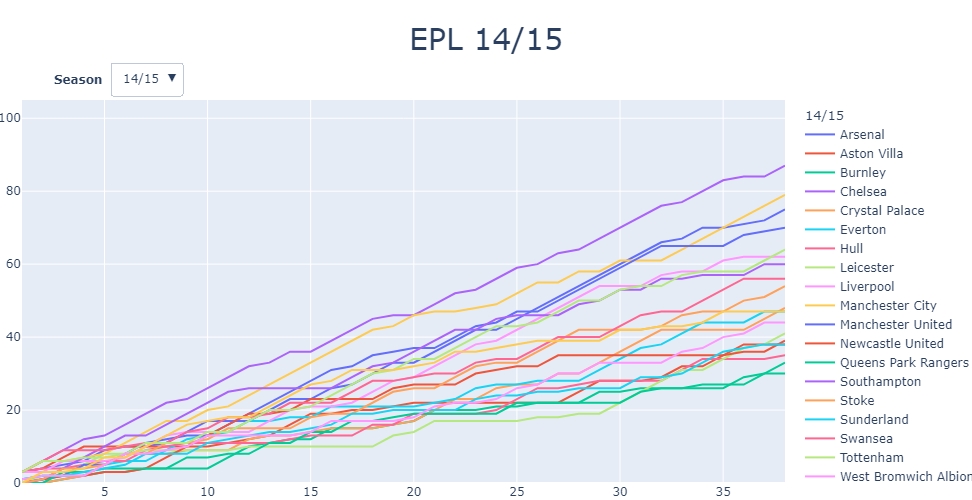

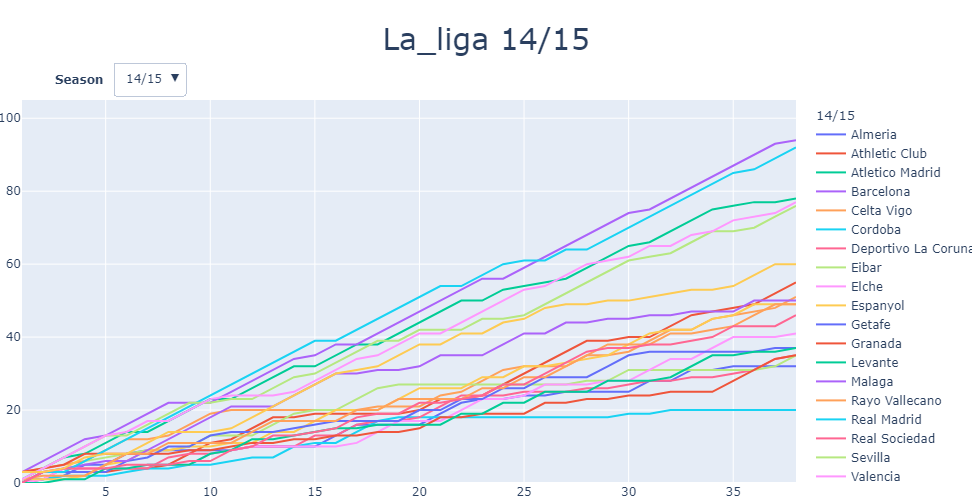

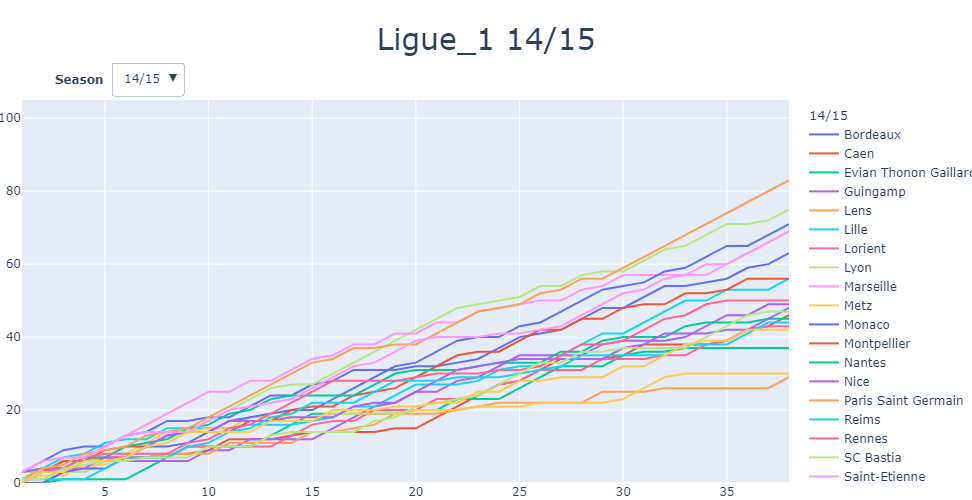

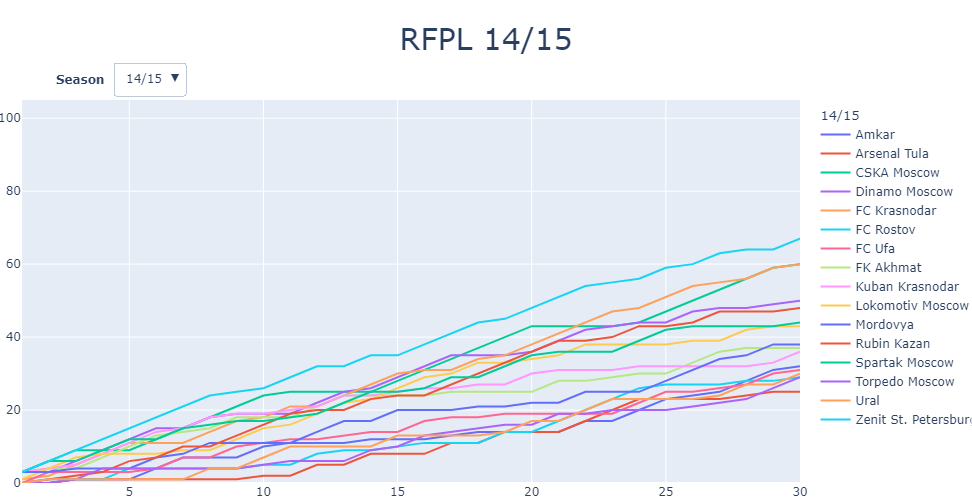

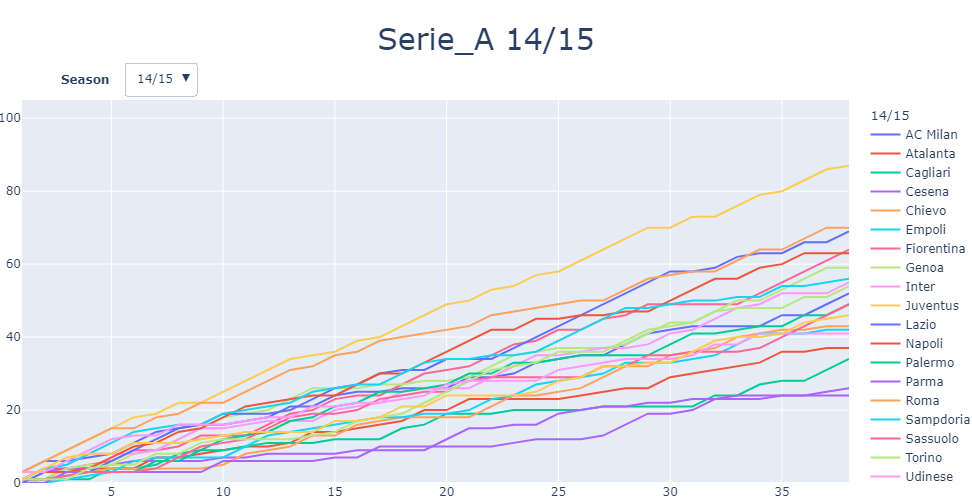

In [20]:
league_list = data_grouped['league'].unique()
open("getting_points_by_each_team_plots.html", "w").close()
file = open("getting_points_by_each_team_plots.html", "w")
for league in league_list:
    fig = mylib.create_figure_withplot_for_league_with_season_dropdown(
        data_grouped[(data_grouped['league'] == league)], league
    )
    file.write(pio.to_html(fig))
    fig.show()
    
file.close()